# Graph Algorithms

Now that we have a way to represent graphs, we can explore common algorithms for analyzing them. The most fundamental operations are *traversals*: systematic ways of visiting every vertex in a graph.

## Depth First Search (DFS)

The *Depth First Search* (DFS) is an algorithm for exploring a graph. The strategy is to go as **deep** as possible down one path before backtracking. 

Imagine exploring a maze: you follow one corridor until you hit a dead end, then you backtrack to the last junction and try the next unexplored path. This "deep" exploration is why it's called Depth First. It's most naturally implemented using recursion.

To avoid getting stuck in infinite loops in graphs with cycles, we must keep track of the vertices we've already visited.

In [1]:
# This cell loads the Graph and Vertex structs and the plotting functions
# from the previous notebook, so this one can run independently.
using NBInclude
@nbinclude("Graph_Basics.ipynb");

In [2]:
function dfs(g::Graph, start)
    # Create a boolean array to track visited vertices.
    # Initially, all are 'false' (unvisited).
    visited = falses(length(g.vertices))
    
    # Define an inner 'helper' function that can be called recursively.
    # This is a common pattern in Julia.
    function visit(ivertex)
        # 1. Mark the current vertex as visited.
        visited[ivertex] = true
        println("Visiting vertex #$ivertex")
        
        # 2. Loop through all neighbors of the current vertex.
        for nb in g.vertices[ivertex].neighbors
            # 3. If we haven't visited this neighbor yet... 
            if !visited[nb]
                # ...recursively call 'visit' on that neighbor.
                # This is the "deep dive" part of the algorithm.
                visit(nb)
            end
        end
    end
    
    # Kick off the recursive process starting from the 'start' vertex.
    visit(start)
    return nothing
end

dfs (generic function with 1 method)

Let's observe the order that the method visits vertices. Note that this order isn't unique; it highly depends on the order of the neighbors in each vertex's adjacency list, which is somewhat arbitrary.

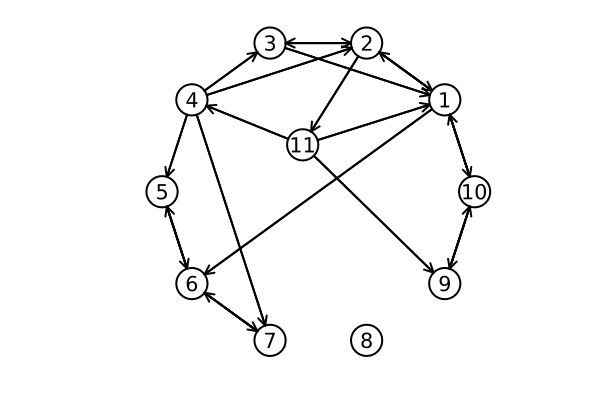

In [3]:
# Plot the modified graph from the previous notebook
plot(g)

In [4]:
# Run the DFS starting from vertex 1.
# Compare the output visiting order to the graph plot.
dfs(g,1) 

Visiting vertex #1
Visiting vertex #2
Visiting vertex #3
Visiting vertex #11
Visiting vertex #4
Visiting vertex #5
Visiting vertex #6
Visiting vertex #7
Visiting vertex #9
Visiting vertex #10


### Path Finding with DFS

A simple application of DFS is to find *a* path between two vertices. We can modify the recursive `visit` function to return a boolean: `true` if it found the destination, `false` otherwise. 

If a recursive call returns `true`, we know the current vertex is *on* the path. We can then build the path by adding the vertex to our path list as the recursion "unwinds".

In [5]:
function find_path_dfs(g::Graph, start, finish)
    visited = falses(length(g.vertices))
    path = Int64[] # This will store our path
    
    function visit(ivertex)
        # 1. Mark this vertex as visited
        visited[ivertex] = true
        
        # 2. Check the base case: did we find the finish?
        if ivertex == finish
            # If yes, add it to the path and return 'true'
            pushfirst!(path, ivertex)
            return true
        end
        
        # 3. Recursively explore neighbors
        for nb in g.vertices[ivertex].neighbors
            if !visited[nb]
                # 4. Check if the recursive call found the path
                if visit(nb)
                    # If it did, that means our *current* vertex is on the path.
                    # Add it to the *front* of the path list.
                    pushfirst!(path, ivertex)
                    # Pass 'true' back up the call stack.
                    return true
                end
            end
        end
        
        # 5. If we're here, no path was found from this vertex.
        return false
    end
    
    visit(start)
    return path
end

find_path_dfs (generic function with 1 method)

We also define a simple utility function for plotting paths in a graph:

In [6]:
function plot_path(g, path)
    # 1. Get the [x,y] coordinates for each vertex ID in the path
    xypath = [v.coordinates for v in g.vertices][path]
    
    # 2. Plot a line connecting them. 
    #    first.(xypath) gets all x-coordinates
    #    last.(xypath) gets all y-coordinates
    plot!(first.(xypath), last.(xypath), color=:red, linewidth=2, label="Path")
end

plot_path (generic function with 1 method)

Let's apply the path-finding method to our graph. Note again that this path depends on the neighbor order. 

Crucially, DFS finds *a* path, but it is **not guaranteed to be the shortest path**.

Path from 10 to 5: [10, 1, 2, 11, 4, 5]


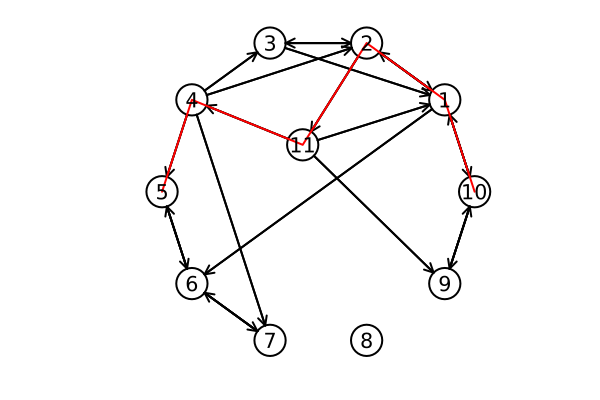

In [7]:
# Find a path from vertex 10 to vertex 5
path = find_path_dfs(g, 10, 5)
println("Path from 10 to 5: $path")

# Plot the graph and the path
plot(g)
plot_path(g, path)

### Other Applications of DFS

DFS is a powerful building block for many other algorithms, including:
(from <https://www.geeksforgeeks.org/applications-of-depth-first-search>)

1.  **Detecting Cycles in a Graph**: A graph has a cycle if the DFS encounters an already visited vertex (a "back edge").
2.  **Path Finding**: As we just saw, we can find a path between two vertices.
3.  **Topological Sorting**: Used for scheduling tasks with dependencies. For example, determining the order to compile code files.
4.  **Testing for Bipartiteness**: We can use DFS to check if a graph can be 2-colored.
5.  **Finding Strongly Connected Components**: In a directed graph, this finds all subgraphs where every vertex is reachable from every other vertex.
6.  **Solving Puzzles**: DFS is excellent for solving puzzles like mazes where you need to explore one full path at a time.

## Breadth First Search (BFS)

An alternative traversal method is the *Breadth First Search* (BFS). Instead of a "deep" dive, BFS explores "wide". 

It's like dropping a stone in a pond: it visits the start node, then all of its *direct neighbors* (1st wave), then all *their* neighbors (2nd wave), and so on. This level-by-level approach is key to its properties.

Instead of recursion, BFS is implemented iteratively using a **Queue**. A queue is a "First-In-First-Out" (FIFO) data structure. We'll use a standard Julia `Vector` and add new nodes to the *end* (`push!`) while taking nodes to visit from the *beginning* (`popfirst!`).

In [8]:
function bfs(g::Graph, start)
    visited = falses(length(g.vertices))
    
    # S is our Queue. We add the 'start' vertex to it.
    S = [start]
    # Mark the start vertex as visited so we don't add it again.
    visited[start] = true
    
    # Loop as long as the queue is not empty
    while !isempty(S)
        # Dequeue: Get the next vertex from the *front* of the queue.
        ivertex = popfirst!(S)
        println("Visiting vertex #$ivertex")
        
        # Look at all its neighbors
        for nb in g.vertices[ivertex].neighbors
            # If we haven't visited this neighbor yet...
            if !visited[nb]
                # ...mark it as visited...
                visited[nb] = true
                # ...and Enqueue it (add it to the *back* of the queue).
                push!(S, nb)
            end
        end
    end
end

bfs (generic function with 1 method)

Running the function on the same graph, we see a very different traversal order. It visits all neighbors of 1 (10, 6, 11) before moving on to *their* neighbors.

In [9]:
bfs(g,1)

Visiting vertex #1
Visiting vertex #2
Visiting vertex #10
Visiting vertex #6
Visiting vertex #3
Visiting vertex #11
Visiting vertex #9
Visiting vertex #7
Visiting vertex #5
Visiting vertex #4


### Shortest Path with BFS

The level-by-level property of BFS guarantees that the first time we find a path to any vertex, we have found the **shortest path** (in terms of the number of edges).

To reconstruct this path, we can't use recursion. Instead, as we visit nodes, we'll store *how* we got to them. We use a `parent` array, where `parent[i]` will store the index of the vertex we *came from* to discover vertex `i`.

After the search finds the `finish` vertex, we can trace this path backward from `finish` to `parent[finish]`, and so on, until we get back to the `start`.

In [10]:
function shortest_path_bfs(g::Graph, start, finish)
    # 'parent[i]' stores the node we came from to get to 'i'.
    # We initialize it to all zeros. 'parent[i] == 0' will mean "not visited".
    parent = zeros(Int64, length(g.vertices))
    
    S = [start] # Our queue
    # Mark 'start' as visited. We use 'start' as its own parent (a sentinel value).
    parent[start] = start
    
    while !isempty(S)
        ivertex = popfirst!(S) # Dequeue
        
        # Optimization: If we just dequeued the 'finish' node, we're done!
        # We've found the shortest path and can stop the search early.
        if ivertex == finish
            break
        end
        
        for nb in g.vertices[ivertex].neighbors
            # Use 'parent[nb] == 0' as our "not visited" check.
            if parent[nb] == 0 
                # This is the key! Record that we found 'nb' *from* 'ivertex'.
                parent[nb] = ivertex
                push!(S, nb) # Enqueue the new neighbor
            end
        end
    end
    
    # --- Path Reconstruction --- 
    path = Int64[]
    iv = finish # Start at the end
    while true
        # Add the current vertex to the front of the path
        pushfirst!(path, iv)
        # If we're back at the start, we're done
        if iv == start
            break
        end
        # "Walk backward" by moving to the parent of the current vertex
        iv = parent[iv]
    end
    return path
end


shortest_path_bfs (generic function with 1 method)

Shortest path from 10 to 5: [10, 1, 6, 5]


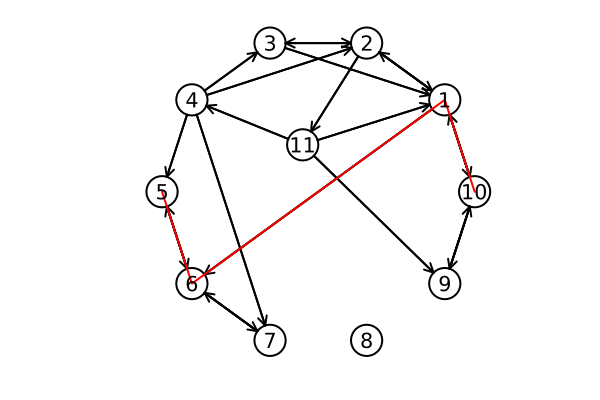

In [11]:
# Find the shortest path from 10 to 5
path = shortest_path_bfs(g, 10, 5)
println("Shortest path from 10 to 5: $path")

# Plot the result. Compare this to the path found by DFS!
plot(g)
plot_path(g, path)

### BFS Application: Optimal Trajectory

Here we consider navigation on a grid, with the goal of reaching a destination with the fewest possible moves. This is a classic shortest path problem!

We can model the grid as a graph:
* Each empty square is a **vertex**.
* An **edge** exists between two vertices if they are adjacent (horizontally, vertically, or diagonally) and neither is a wall.

The shortest path in the maze is now just a `shortest_path_bfs` problem on this graph!

In [12]:
# This string defines the maze layout. 'O' is a wall, '.' is empty.
field = """
....O....
O.O.O.O..
..O...O.O
.OOOOOO.O
....OO..O
.O...OOOO
.O.......
.OOOOOO..
......O..
......O..
"""
n = 10

# --- Convert the string into a graph --- 

# 1. Create a 10x10 matrix 'F' where 1=Wall, 0=Empty
F = Int.(reverse(reshape(collect(field), n, n) .== 'O', dims=2))

# 2. Create a new empty graph
g1 = Graph([])
nbr = 0 # This will be the vertex number, from 1 to 100

# 3. Loop over every cell (i,j) in the grid
for j = 1:n
    for i = 1:n
        nbr += 1
        nb = Int64[] # List of neighbors for this vertex
        
        # 4. Check all 8 adjacent cells (and the cell itself)
        for dj = -1:1
            for di = -1:1
                # 5. Check if the neighbor (i+di, j+dj) is inside the grid
                if 1 ≤ i+di ≤ n && 1 ≤ j+dj ≤ n
                    # 6. If *both* our cell and the neighbor cell are empty...
                    if F[i,j] == 0 && F[i+di,j+dj] == 0
                        # ...add an edge between them!
                        # (nbr + di + n*dj) is the vertex number of the neighbor
                        push!(nb, nbr + di + n*dj)
                    end
                end
            end
        end
        # 7. Create the vertex with its list of neighbors and coordinates
        v = Vertex(nb, coordinates=[i,j])
        push!(g1.vertices, v)
    end
end

The shortest path algorithm can now find the optimal trajectory:

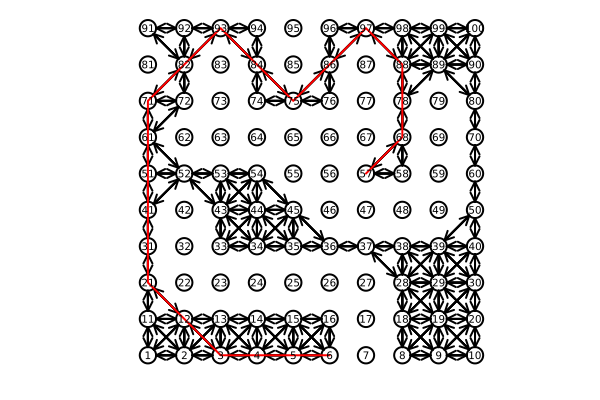

In [13]:
# Find the shortest path from vertex 6 to vertex 57
path = shortest_path_bfs(g1, 6, 57)

# Plot the maze graph
plot(g1, scale=0.5)
# Plot the shortest path over it
plot_path(g1, path)

### Other Applications of BFS

Like DFS, BFS is a building block for many other important algorithms.
(from <https://www.geeksforgeeks.org/applications-of-breadth-first-traversal>)

1.  **Shortest Path in Unweighted Graphs**: As we just demonstrated, BFS is the standard way to find the path with the fewest edges.
2.  **Peer-to-Peer Networks**: In networks like BitTorrent, BFS is used to find all neighbor nodes.
3.  **Search Engine Crawlers**: Crawlers use BFS to build an index, visiting pages one "click" away, then two "clicks" away, and so on.
4.  **Social Networks**: Finding people within a certain "distance" (e.g., "friends of friends") is a BFS problem.
5.  **GPS Navigation**: Used to find all neighboring locations (a key part of more complex algorithms like A*).
6.  **Cycle Detection in Undirected Graphs**: BFS can be used (along with DFS) to detect cycles.
7.  **Testing for Bipartiteness**: BFS is also an excellent way to check if a graph can be 2-colored.